In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andrewmvd/face-mask-detection

 96% 380M/398M [00:02<00:00, 169MB/s]
100% 398M/398M [00:02<00:00, 167MB/s]


In [ ]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import zipfile
from pathlib import Path
import numpy as np
import shutil
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
ROOT_DIR = ""
DATA_FILE = "face-mask-detection.zip"
IMAGE_EXT = ".png"

DATA_DIR = join(ROOT_DIR, "mask")
IMAGE_DIR = join(DATA_DIR, "images")
LABEL_DIR = join(DATA_DIR, "annotations")
PROCESSED_LABEL_DIR = join(DATA_DIR, "processed_annotations")
TRAIN_DATA_DIR = join(DATA_DIR, "train")
VALID_DATA_DIR = join(DATA_DIR, "valid")

with zipfile.ZipFile(join(ROOT_DIR, DATA_FILE), 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

Path(TRAIN_DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(VALID_DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(TRAIN_DATA_DIR + "/images").mkdir(parents=True, exist_ok=True)
Path(TRAIN_DATA_DIR + "/labels").mkdir(parents=True, exist_ok=True)
Path(VALID_DATA_DIR + "/images").mkdir(parents=True, exist_ok=True)
Path(VALID_DATA_DIR + "/labels").mkdir(parents=True, exist_ok=True)
Path(PROCESSED_LABEL_DIR).mkdir(parents=True, exist_ok=True)

# referred to https://github.com/pjreddie/darknet/blob/master/scripts/voc_label.py
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x,y,w,h)

# referred to https://github.com/pjreddie/darknet/blob/master/scripts/voc_label.py
def convert_annotation(classes, input_path, output_path):
    basename = os.path.basename(input_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(input_path)
    out_file = open(output_path + "/" + basename_no_ext + '.txt', 'w')

    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

    in_file.close()
    out_file.close()

paths = glob.glob(LABEL_DIR + '/*.xml')

for xml_path in tqdm(paths):
    convert_annotation(classes, xml_path, PROCESSED_LABEL_DIR)

label_files = glob.glob(PROCESSED_LABEL_DIR + '/*.txt')

train_indices, valid_indices = train_test_split(
    np.arange(len(label_files)), test_size=0.2, random_state=42, shuffle=True)

train_labels = []
for idx in train_indices:
    train_labels.append(label_files[idx])

valid_labels = []
for idx in valid_indices:
    valid_labels.append(label_files[idx])

for label_path in train_labels:
    basename = os.path.basename(label_path)
    basename_no_ext = os.path.splitext(basename)[0]

    shutil.move(label_path, join(TRAIN_DATA_DIR, "labels", basename_no_ext + ".txt"))
    shutil.move(join(IMAGE_DIR, basename_no_ext + IMAGE_EXT), join(TRAIN_DATA_DIR, "images", basename_no_ext + IMAGE_EXT))

for label_path in valid_labels:
    basename = os.path.basename(label_path)
    basename_no_ext = os.path.splitext(basename)[0]

    shutil.move(label_path, join(VALID_DATA_DIR, "labels", basename_no_ext + ".txt"))
    shutil.move(join(IMAGE_DIR, basename_no_ext + IMAGE_EXT), join(VALID_DATA_DIR, "images", basename_no_ext + IMAGE_EXT))


100%|██████████| 853/853 [00:00<00:00, 4617.01it/s]


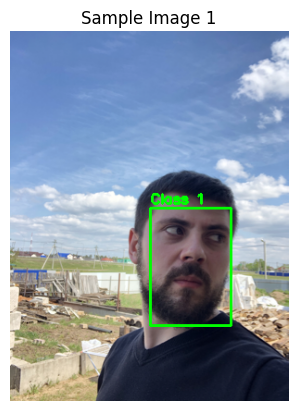

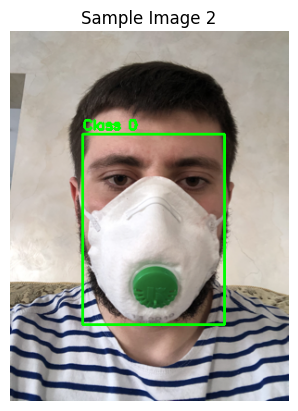

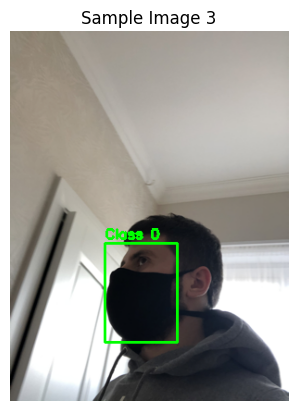

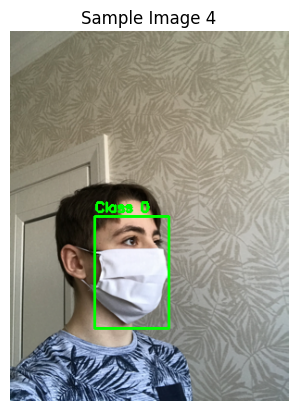

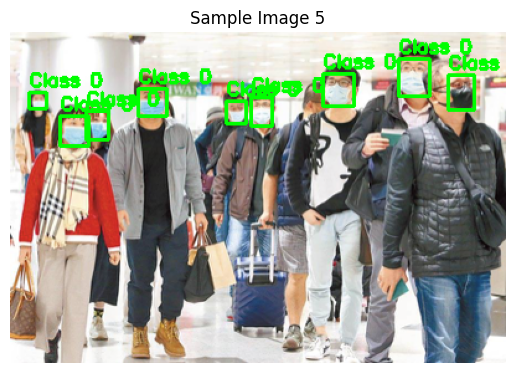

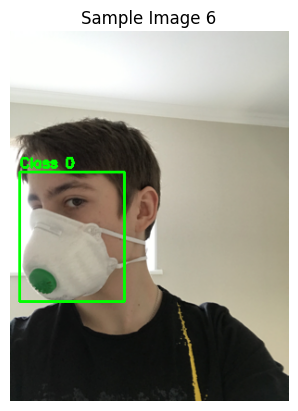

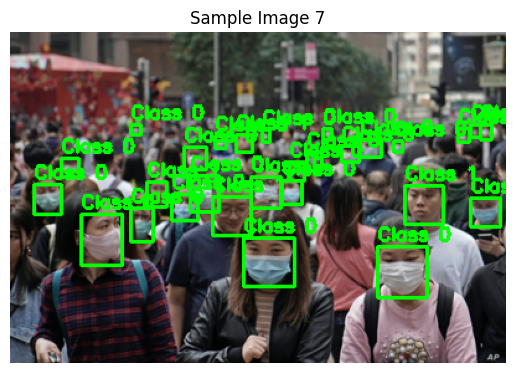

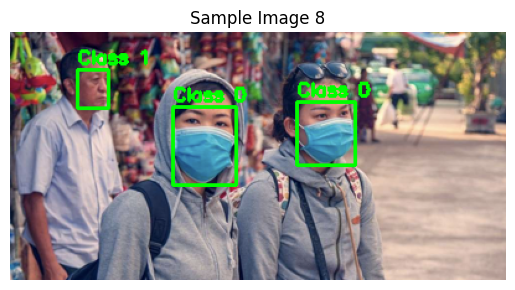

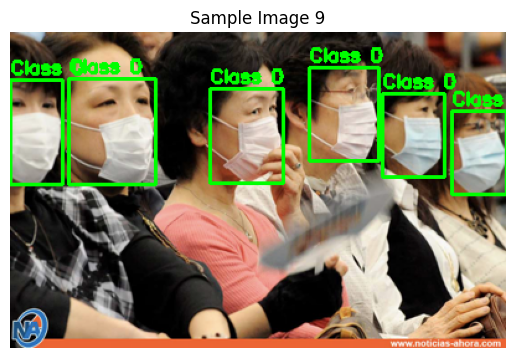

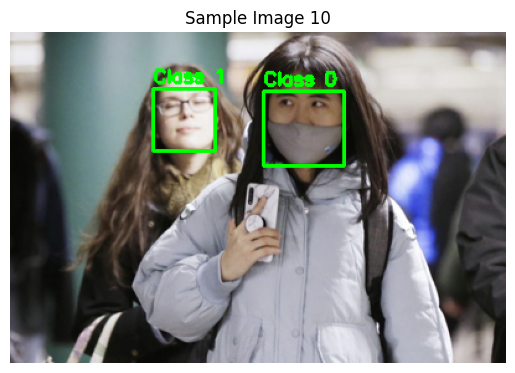

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import matplotlib.pyplot as plt

# Function to read YOLO format annotations and extract bounding box information
def read_yolo_annotations(file_path, image_shape):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        bounding_boxes = []

        for line in lines:
            data = line.split()
            class_label = int(data[0])
            center_x, center_y, width, height = map(float, data[1:])

            # Convert normalized coordinates to absolute coordinates
            image_width, image_height = image_shape[1], image_shape[0]
            x = int((center_x - width / 2) * image_width)
            y = int((center_y - height / 2) * image_height)
            w = int(width * image_width)
            h = int(height * image_height)

            bounding_boxes.append((x, y, w, h, class_label))

        return bounding_boxes

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, bounding_boxes):
    for x, y, w, h, class_label in bounding_boxes:
        color = (0, 255, 0)  # Green color for bounding boxes
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, f'Class {class_label}', (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Function to display images with bounding boxes
def display_images_with_boxes(image_folder, label_folder, num_samples=3):
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i in range(min(num_samples, len(image_files))):
        image_file = image_files[i]
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + '.txt')

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        bounding_boxes = read_yolo_annotations(label_path, img.shape)
        draw_bounding_boxes(img_rgb, bounding_boxes)

        plt.imshow(img_rgb)
        plt.title(f'Sample Image {i + 1}')
        plt.axis('off')
        plt.show()


if __name__ == "__main__":

    image_folder_path = 'mask//train//images'
    label_folder_path = 'mask//train//labels'

    display_images_with_boxes(image_folder_path, label_folder_path, num_samples=10)


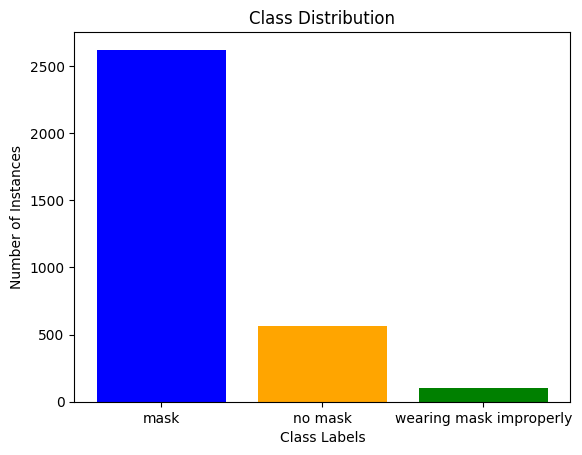

In [ ]:
def count_class_occurrences(file_path):
    class_counts = {'mask': 0, 'no mask': 0, 'wearing mask improperly': 0}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            # Assuming the class index is an integer and it is the first element in each line
            class_index = int(line.split()[0])

            # Mapping class index to class label
            if class_index == 0:
                class_label = 'mask'
            elif class_index == 1:
                class_label = 'no mask'
            elif class_index == 2:
                class_label = 'wearing mask improperly'
            else:
                # Handle unknown class index
                class_label = 'unknown'

            class_counts[class_label] += 1

    return class_counts

# Function to plot bar chart for class distribution
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(classes, counts, color=['blue', 'orange', 'green'])
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution')
    plt.xticks(classes)

    plt.show()

if __name__ == "__main__":

    labels_folder_path = 'mask//train//labels'

    # Get a list of all files in the folder
    all_files = [f for f in os.listdir(labels_folder_path) if os.path.isfile(os.path.join(labels_folder_path, f))]

    total_class_counts = {'mask': 0, 'no mask': 0, 'wearing mask improperly': 0}

    for file_name in all_files:
        file_path = os.path.join(labels_folder_path, file_name)
        class_counts = count_class_occurrences(file_path)
        # print(file_name)
        # print(class_counts)
        # Accumulate counts across all files
        for class_label, count in class_counts.items():
            total_class_counts[class_label] += count

    # Plot the overall class distribution
    plot_class_distribution(total_class_counts)


### **yolo v5**

In [ ]:
import torch
import os
import glob
from IPython.display import Image, display

#print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
#!pip install -U -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.72 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
/content/yolov5


In [ ]:
!python train.py --img 640 --batch 16 --epochs 25 --data mask_config.yaml --weights yolov5s.pt --workers 0

In [ ]:
!zip -r /content/file.zip /content/yolov5/runs/detect/exp7

In [ ]:
from google.colab import files
#files.download("/content/file.zip")
files.download("/content/yolov5/runs/detect/exp7")

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.4 --source ../mask/valid/images

In [ ]:
from utils.plots import plot_results
plot_results('runs/train/exp/results.csv')